# Análisis de Conversión por Perfil de Cliente 

**Objetivo:** Responder a la pregunta clave: *¿Qué tipo de cliente convierte más?*

**Dataset:** `df_model_ready.csv` (Cargado desde `Proyecto EDA/Datos procesados`)

**Tareas:**
1. Crear variable `converted`. Saber quien compra y quien no compra.
2. Analizar tasa de conversión por segmentos:
    - `age_group` ¿Compran más los jóvenes o los mayores? 
    - `tenure` (antigüedad) ¿Son más fieles los clientes nuevos o los veteranos?
    - `balance`  ¿Influye tener más saldo en la cuenta?
    - `logins_6m` ¿El que entra más a la web compra más?
3. Detectar segmentos de mayor y menor rendimiento.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns




In [5]:
# Cargar datos procesados 
df = pd.read_csv("../Datos procesados/df_model_ready.csv")
print("Datos cargados correctamente!")
df.head()
    
   

df.head()

Datos cargados correctamente!


,client_id,age_group,gender,tenure_months,num_accounts,balance,balance_log,logins_6m,calls_6m,experiment_group,web_events,web_visits,web_steps,web_confirms
0,836976,60.5,Unknown,73.0,2.0,45105.30,10.716777,9.0,6.0,Test,11,2,5,3
1,2304905,58.0,Unknown,94.0,2.0,110860.30,11.616035,9.0,6.0,Control,6,1,5,1
2,1439522,32.0,Unknown,64.0,2.0,52467.79,10.867974,9.0,6.0,Test,5,2,4,0
3,1562045,49.0,Male,198.0,2.0,67454.65,11.119226,6.0,3.0,Test,1,1,1,0
4,5126305,33.0,Female,145.0,2.0,103671.75,11.548995,3.0,0.0,Control,1,1,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70609 entries, 0 to 70608
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         70609 non-null  int64  
 1   age_group         70220 non-null  float64
 2   gender            70609 non-null  object 
 3   tenure_months     70595 non-null  float64
 4   num_accounts      70595 non-null  float64
 5   balance           70595 non-null  float64
 6   balance_log       70595 non-null  float64
 7   logins_6m         70595 non-null  float64
 8   calls_6m          70595 non-null  float64
 9   experiment_group  70609 non-null  object 
 10  web_events        70609 non-null  int64  
 11  web_visits        70609 non-null  int64  
 12  web_steps         70609 non-null  int64  
 13  web_confirms      70609 non-null  int64  
dtypes: float64(7), int64(5), object(2)
memory usage: 7.5+ MB


In [7]:
# Crear variable converted (1 si web_confirms > 0, sino 0)
df["converted"] = (df["web_confirms"] > 0).astype(int)
# Ver distribución general
df["converted"].value_counts(normalize=True)

converted
1    0.676968
0    0.323032
Name: proportion, dtype: float64

# CONTEXTO: La tasa de conversión global es del 67.7%.
- Esto significa que, del total de clientes analizados, aproximadamente 2 de cada 3
  completaron al menos una acción en la web (web_confirms > 0).

- Usamos esta media global como LÍNEA DE REFERENCIA (línea roja) en cada gráfico
  para identificar rápidamente qué segmentos rinden por encima o por debajo
  de lo esperado. Un segmento que supera la línea roja convierte mejor que
  el promedio general; uno que está por debajo, peor.

- Esta métrica es independiente del test A/B: es el punto de partida
 ANTES de analizar el efecto del experimento sobre cada segmento.

In [8]:
# Exploracion edad
print("Estadísticas de age_group:")
print(df['age_group'].describe())
print(f"\nMínimo: {df['age_group'].min()}")
print(f"\nMáximo: {df['age_group'].max()}")

Estadísticas de age_group:
count    70220.000000
mean        46.601581
std         15.478538
min         18.000000
25%         33.000000
50%         47.000000
75%         59.000000
max         96.000000
Name: age_group, dtype: float64

Mínimo: 18.0

Máximo: 96.0


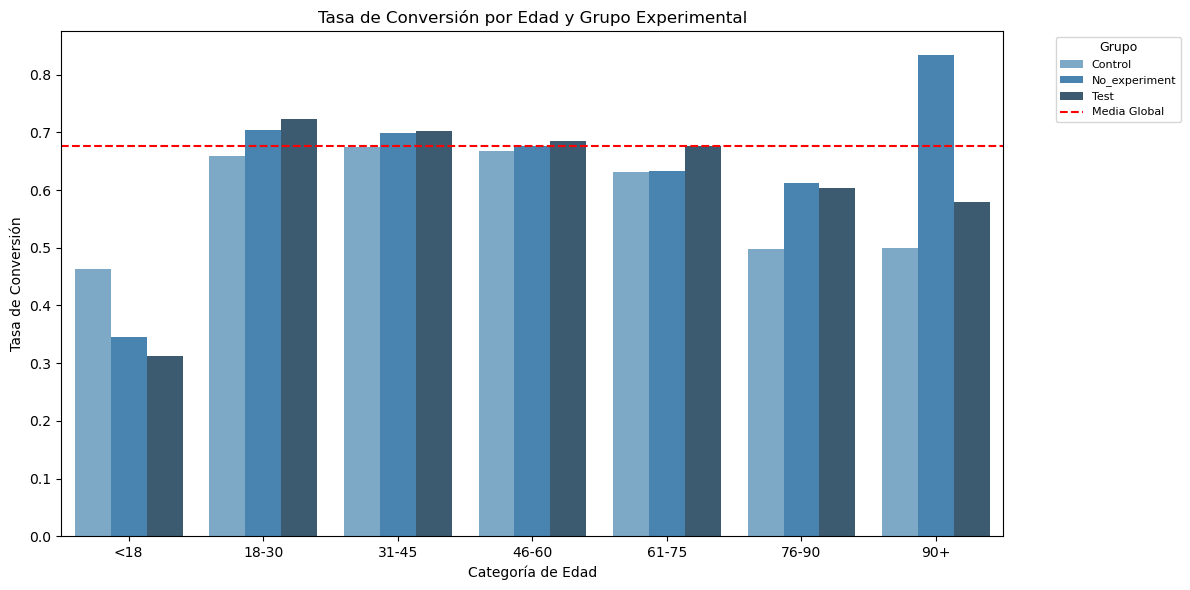

In [9]:
# Crear categorías de edad con rangos claros
bins_edad = [0, 18, 30, 45, 60, 75, 90, float('inf')]
labels_edad = ['<18', '18-30', '31-45', '46-60', '61-75', '76-90', '90+']
df['age_category'] = pd.cut(df['age_group'], bins=bins_edad, labels=labels_edad)
# Análisis por Edad + Grupo Experimental
plt.figure(figsize=(12, 6))
age_exp = df.groupby(["age_category", "experiment_group"], observed=False)["converted"].mean().reset_index()
sns.barplot(data=age_exp, x="age_category", y="converted", hue="experiment_group", palette="Blues_d")
plt.title("Tasa de Conversión por Edad y Grupo Experimental")
plt.ylabel("Tasa de Conversión")
plt.xlabel("Categoría de Edad")
plt.axhline(df["converted"].mean(), color="red", linestyle="--", label="Media Global")
plt.legend(title="Grupo", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8, title_fontsize=9)
plt.tight_layout() 

plt.show()

# INSIGHT (Edad + Grupo Experimental):
- Los clientes de 18-30 del grupo TEST son los que más convierten (~73%),
  superando a No_experiment (~71%) y claramente al Control (~66%).
- En los rangos de 18-30, 31-45, 46-60 y 76-90, el grupo TEST supera al Control,
  lo que sugiere que el experimento tiene un efecto positivo en la conversión
  para clientes adultos.
- Los menores de 18 convierten muy por debajo de la media en TODOS los grupos,
  confirmando que la edad joven es un factor limitante independiente del experimento.
  Curiosamente, en este rango el Control (~46%) supera al Test (~31%).
- En el rango 76-90, el grupo Control cae a ~50%, mientras Test y No_experiment
  se mantienen en ~60%, indicando que el experimento beneficia a los mayores.
- El grupo 90+ muestra un pico atípico en No_experiment (~84%),
  probablemente por tamaño de muestra reducido. Este dato debe interpretarse
  con cautela.

In [10]:
# Exploracion antiguedad
print("Estadísticas de age_group:")
print(df['tenure_months'].describe())
print(f"\nMínimo: {df['tenure_months'].min()}")
print(f"\nMáximo: {df['tenure_months'].max()}")

Estadísticas de age_group:
count    70595.000000
mean       150.659367
std         82.089854
min         33.000000
25%         82.000000
50%        136.000000
75%        192.000000
max        749.000000
Name: tenure_months, dtype: float64

Mínimo: 33.0

Máximo: 749.0


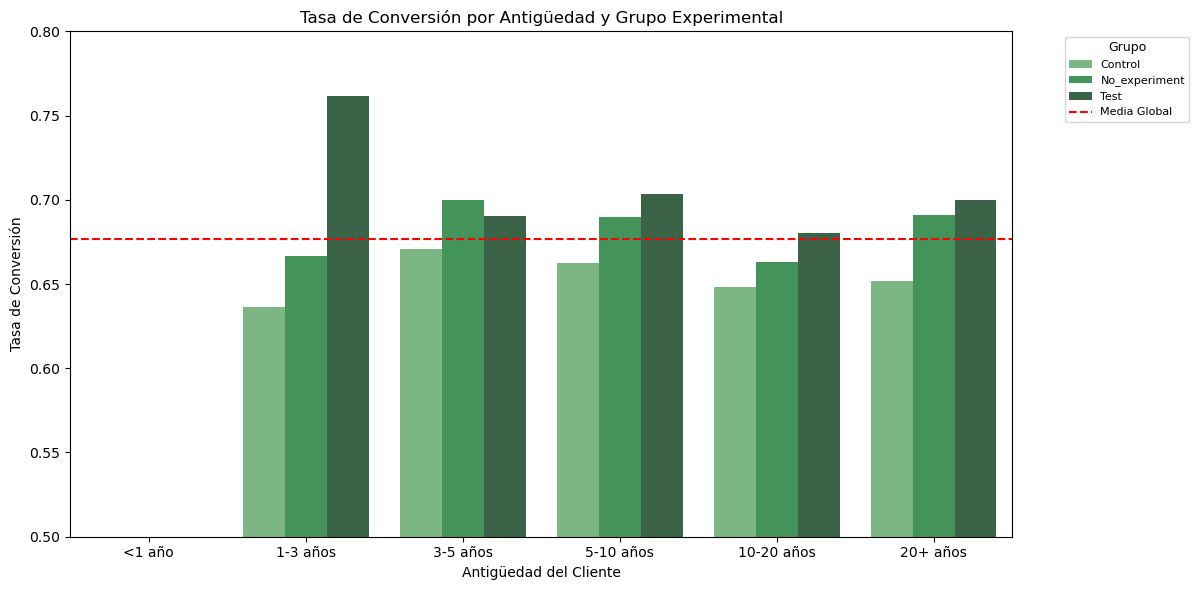

In [11]:
# Análisis por ANTIGÜEDAD + Grupo Experimental
# Crear categorías de antigüedad (meses → etiquetas en años)
bins_tenure = [0, 12, 36, 60, 120, 240, float('inf')]
labels_tenure = ['<1 año', '1-3 años', '3-5 años', '5-10 años', '10-20 años', '20+ años']
df['tenure_group'] = pd.cut(df['tenure_months'], bins=bins_tenure, labels=labels_tenure)
# Análisis por Antigüedad + Grupo Experimental
plt.figure(figsize=(12, 6))
tenure_exp = df.groupby(["tenure_group", "experiment_group"], observed=False)["converted"].mean().reset_index()
sns.barplot(data=tenure_exp, x="tenure_group", y="converted", hue="experiment_group", palette="Greens_d")
plt.title("Tasa de Conversión por Antigüedad y Grupo Experimental")
plt.ylabel("Tasa de Conversión")
plt.xlabel("Antigüedad del Cliente")
plt.axhline(df["converted"].mean(), color="red", linestyle="--", label="Media Global")
plt.legend(title="Grupo", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8, title_fontsize=9)
plt.tight_layout()
plt.ylim(0.5, 0.8)
plt.show()



# INSIGHT (Antigüedad + Grupo Experimental):
- Aunque la antigüedad por sí sola NO predice la conversión, al cruzar
   con el grupo experimental se revela un hallazgo clave:
- El grupo TEST supera consistentemente al grupo Control en TODOS los
   segmentos de antigüedad, especialmente en 1-3 años.
- Esto confirma que el experimento tiene un efecto positivo en la conversión
   independientemente de cuánto tiempo lleve el cliente.
- El grupo "No_experiment" se sitúa entre Test y Control, lo cual es lógico
   al no haber recibido ninguna intervención específica.

In [12]:
# Exploracion la distribución de balance antes de agrupar
pd.set_option('display.float_format', '{:,.2f}'.format)
print("Estadísticas de balance:")
print(df['balance'].describe())
print(f"Mínimo: {df['balance'].min()}")
print(f"Máximo: {df['balance'].max()}")
print(f"Percentiles:")
print(df['balance'].quantile([0.1, 0.25, 0.5, 0.75, 0.9]))

Estadísticas de balance:
count       70,595.00
mean       147,445.24
std        301,508.71
min         13,789.42
25%         37,346.83
50%         63,332.90
75%        137,544.90
max     16,320,040.15
Name: balance, dtype: float64
Mínimo: 13789.419999999998
Máximo: 16320040.15
Percentiles:
0.10    27,586.95
0.25    37,346.83
0.50    63,332.90
0.75   137,544.90
0.90   319,358.70
Name: balance, dtype: float64


- Para balance usamos PERCENTILES (P10, P25, P50, P75, P90) 
- porque la distribución está muy sesgada a la derecha:
- Media: 147K vs Mediana: 63K (gran diferencia = sesgo)
- Rango: 13K a 16M (extremos muy alejados)
- Con percentiles garantizamos grupos con tamaño similar, haciendo el análisis más fiable.

C:\Users\manue\AppData\Local\Temp\ipykernel_23612\3856410983.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  balance_exp = df.groupby(["balance_group", "experiment_group"])["converted"].mean().reset_index()


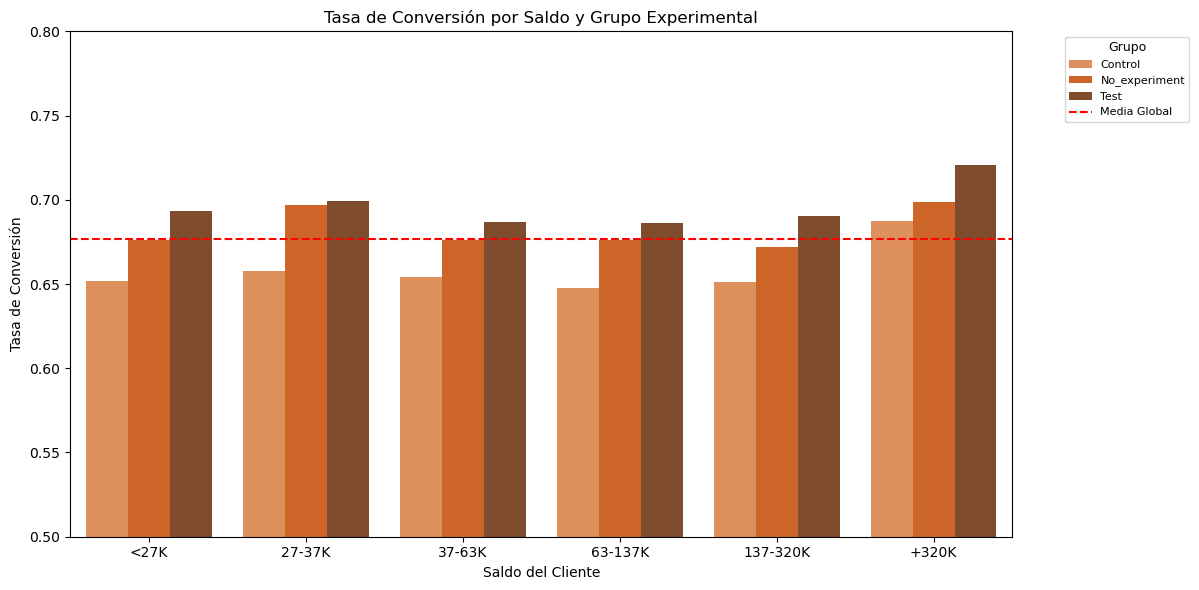

In [13]:
# Análisis por BALANCE + Grupo Experimental
# Objetivo: ¿Influye tener más dinero en la conversión segun el grupo experimental
bins_balance = [0, 27000, 37000, 63000, 137000, 320000, np.inf]
labels_balance = ['<27K', '27-37K', '37-63K', '63-137K', '137-320K', '+320K']
df['balance_group'] = pd.cut(df['balance'], bins=bins_balance, labels=labels_balance)
# Conversión por saldo y grupo experimental
plt.figure(figsize=(12, 6))
balance_exp = df.groupby(["balance_group", "experiment_group"])["converted"].mean().reset_index()
sns.barplot(data=balance_exp, x="balance_group", y="converted", hue="experiment_group", palette="Oranges_d")
plt.title("Tasa de Conversión por Saldo y Grupo Experimental")
plt.ylabel("Tasa de Conversión")
plt.xlabel("Saldo del Cliente")
plt.axhline(df["converted"].mean(), color="red", linestyle="--", label="Media Global")
plt.legend(title="Grupo", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8, title_fontsize=9)
plt.tight_layout()
plt.ylim(0.5, 0.8) 
plt.show()

# INSIGHT (Balance + Grupo Experimental):
- El saldo del cliente NO tiene un impacto significativo en la conversión.
- Todos los segmentos oscilan muy cerca de la media global (~67.7%).
- Sin embargo, el patrón Test > No_experiment > Control se repite de nuevo
  en casi todos los rangos de saldo, confirmando que el experimento funciona
  independientemente del dinero en la cuenta.
- Los clientes con +320K del grupo Test alcanzan la conversión más alta (~72%),
  pero la diferencia es modesta.
- Conclusión: el saldo no predice la conversión, pero el grupo experimental sí.

In [14]:
# Exploracion distribución de logins_6m 
pd.set_option('display.float_format', '{:,.2f}'.format)
print("Estadísticas de login_6m:")
print(df['logins_6m'].describe())
print(f"Mínimo: {df['logins_6m'].min()}")
print(f"Máximo: {df['logins_6m'].max()}")
print(f"Percentiles:")
print(df['logins_6m'].quantile([0.1, 0.25, 0.5, 0.75, 0.9]))

Estadísticas de login_6m:
count   70,595.00
mean         5.57
std          2.35
min          1.00
25%          4.00
50%          5.00
75%          7.00
max          9.00
Name: logins_6m, dtype: float64
Mínimo: 1.0
Máximo: 9.0
Percentiles:
0.10   3.00
0.25   4.00
0.50   5.00
0.75   7.00
0.90   9.00
Name: logins_6m, dtype: float64


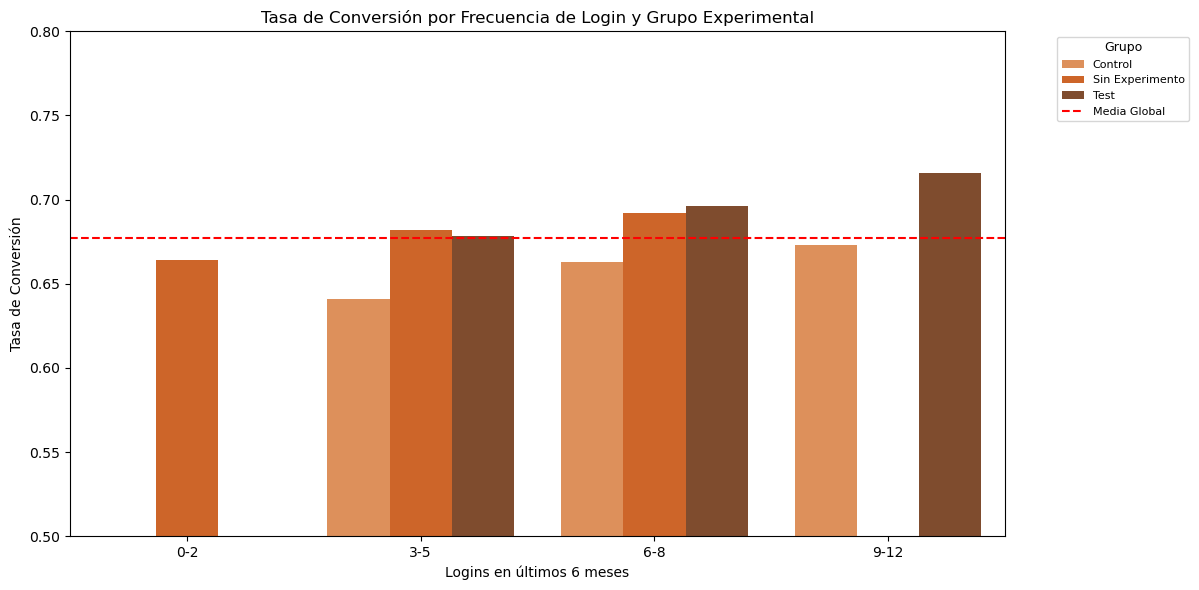

In [15]:
# Crear categorías de frecuencia de login
bins_logins = [0, 2, 5, 8, float('inf')]
labels_logins = ['0-2', '3-5', '6-8', '9-12']
df['login_group'] = pd.cut(df['logins_6m'], bins=bins_logins, labels=labels_logins)
# Análisis por Logins + Grupo Experimental
plt.figure(figsize=(12, 6))
login_exp = df.groupby(["login_group", "experiment_group"], observed=False)["converted"].mean().reset_index()
login_exp['experiment_group'] = login_exp['experiment_group'].replace({'No_experiment': 'Sin Experimento'})
sns.barplot(data=login_exp, x="login_group", y="converted", hue="experiment_group", palette="Oranges_d")
plt.title("Tasa de Conversión por Frecuencia de Login y Grupo Experimental")
plt.ylabel("Tasa de Conversión")
plt.xlabel("Logins en últimos 6 meses")
plt.axhline(df["converted"].mean(), color="red", linestyle="--", label="Media Global")
plt.legend(title="Grupo", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8, title_fontsize=9)
plt.tight_layout() 
plt.ylim(0.5, 0.8)
plt.show()

In [16]:
# Ver cuántos clientes hay en cada combinación
print(df.groupby(['login_group', 'experiment_group']).size().unstack(fill_value=0))

experiment_group  Control  No_experiment   Test
login_group                                    
0-2                     0           5947      0
3-5                 10351           7268  12098
6-8                  7317           6892   8372
9-12                 5859              0   6491


C:\Users\manue\AppData\Local\Temp\ipykernel_23612\3108982273.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(['login_group', 'experiment_group']).size().unstack(fill_value=0))


# INSIGHT (Logins + Grupo Experimental):
- El test A/B solo incluye clientes con 3+ logins, excluyendo a los menos
  activos. Esto sugiere que el experimento fue diseñado para usuarios
  con un nivel mínimo de engagement.
- En los segmentos donde los tres grupos coexisten (3-5 y 6-8 logins),
  el grupo Test supera consistentemente al Control.
- Los clientes más activos (9-12 logins) muestran la mayor tasa de
  conversión en el grupo Test (~71%), confirmando que usuarios más
  comprometidos responden mejor al experimento.
- Los clientes poco activos (0-2 logins) que no participaron en el
  experimento tienen una conversión de ~67%, cercana a la media global.

In [17]:
# Segmentos con datos reales (excluimos combinaciones sin clientes)
segmentos = {
    'Edad': 'age_category',
    'Antigüedad': 'tenure_group',
    'Balance': 'balance_group',
    'Logins': 'login_group'
}
tablas = []
for nombre, columna in segmentos.items():
    tabla = df.groupby([columna, 'experiment_group'])['converted'].agg(['mean', 'count']).reset_index()
    tabla = tabla.rename(columns={columna: 'segmento'})
    tabla['variable'] = nombre
    tablas.append(tabla)
resumen = pd.concat(tablas, ignore_index=True)
resumen['mean'] = resumen['mean'].fillna(0).round(3)
resumen['count'] = resumen['count'].fillna(0).astype(int)
print(resumen)


   segmento experiment_group  mean  count variable
0       <18          Control  0.46     41     Edad
1       <18    No_experiment  0.35     81     Edad
2       <18             Test  0.31     32     Edad
3     18-30          Control  0.66   4121     Edad
4     18-30    No_experiment  0.70   4570     Edad
..      ...              ...   ...    ...      ...
64      6-8    No_experiment  0.69   6892   Logins
65      6-8             Test  0.70   8372   Logins
66     9-12          Control  0.67   5859   Logins
67     9-12    No_experiment  0.00      0   Logins
68     9-12             Test  0.72   6491   Logins

[69 rows x 5 columns]


C:\Users\manue\AppData\Local\Temp\ipykernel_23612\1445008264.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabla = df.groupby([columna, 'experiment_group'])['converted'].agg(['mean', 'count']).reset_index()
C:\Users\manue\AppData\Local\Temp\ipykernel_23612\1445008264.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabla = df.groupby([columna, 'experiment_group'])['converted'].agg(['mean', 'count']).reset_index()
C:\Users\manue\AppData\Local\Temp\ipykernel_23612\1445008264.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pa

# Resumen Final: Análisis de Conversión por Segmentos
**Media global de conversión: ~68%**
## Principales Hallazgos
### 1. El experimento (Test) mejora la conversión
- El grupo Test aparece en 4 de los 5 segmentos con mayor conversión.
- En los segmentos donde coexisten los tres grupos (3-5 y 6-8 logins, 18-60 edad),
  Test supera consistentemente a Control.
- Esto confirma que el experimento tiene un efecto positivo en la conversión.
### 2. Perfil del cliente que más convierte
- Edad: 18-30 años (Test: 72%)
- Balance: +320K (Test: 72%)
- Logins: 9-12 en 6 meses (Test: 72%)
- Antigüedad: 1-3 años (Test: 76%, aunque con muestra pequeña de 42 clientes)
### 3. La edad es el mayor factor limitante
- Los 5 segmentos con menor conversión son todos de edades extremas (<18 y 76-90/90+).
- Los menores de 18 tienen la peor conversión en todos los grupos (31%-46%),
  muy por debajo de la media global.
- Esto indica que la edad joven limita la conversión independientemente del experimento.
### 4. Precaución con muestras pequeñas
- El segmento 90+ Sin Experimento muestra 83% de conversión, pero solo tiene 6 clientes.
- El segmento 1-3 años Test muestra 76%, pero solo tiene 42 clientes.
- Estos resultados no son estadísticamente fiables y deben interpretarse con cautela.
## Top 5 Segmentos
| Ranking | Segmento | Grupo | Conversión | Clientes |
|---------|----------|-------|------------|----------|
|  1 | 18-30 (Edad) | Test | 72% | 4,805 |
|  2 | +320K (Balance) | Test | 72% | 2,671 |
|  3 | 9-12 (Logins) | Test | 72% | 6,491 |
|  1 | <18 (Edad) | Test | 31% | 32 |
|  2 | <18 (Edad) | Sin Experimento | 35% | 81 |
|  3 | 76-90 (Edad) | Control | 50% | 572 |
*Nota: Se excluyen del ranking los segmentos con menos de 30 clientes por fiabilidad estadística.*

In [19]:
resumen.to_csv('../Datos procesados/tabla_conversion.csv', index=False)
print("Tabla exportada correctamente ")

Tabla exportada correctamente 
